# Imports and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/My Drive/Dogs Project')
gdrive_path = os.getcwd()

In [ ]:
# update google colab to the latest version of fastai
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 9.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 


In [ ]:
!pip install PyGithub

     |████████████████████████████████| 296kB 8.4MB/s 


In [ ]:
import os
import shutil
from datetime import datetime
import numpy as np
import pandas as pd
import tarfile
from io import BytesIO
from base64 import b64encode
from github import Github
from IPython.display import Markdown, display

# according to fastai book, use the star import notation despite python best practices
from fastai.vision.all import *
from fastai.vision.widgets import *

In [ ]:
SEED = 42

def set_seed(seed, dls=None, use_cuda=True):
    # For reproducibility. Run before any fits.
    # see 1: https://github.com/fastai/fastai/issues/2832 and
    # and 2: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/28
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    random.seed(seed) # Python

    if dls is not None:  # DataLoaders object
        dls.rng.seed(seed)

    if use_cuda: # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
VALID_PCT = 0.2
TEST_PCT = 0.1
IMAGE_SIZE = 128

# Download, organize, and import data

In [ ]:
# remove pre-downloaded files if necessary

try:
    shutil.rmtree('/root/.fastai')
except FileNotFoundError:
    pass

In [ ]:
download_path = Path('/root/.fastai/data/images')
os.makedirs(download_path)

In [ ]:
dogs = ['Affenpinscher',
 'Afghan Hound',
 'African Hunting Dog',
 'Airedale Terrier',
 'Akita',
 'American Staffordshire Terrier',
 'Anatolian Shepherd Dog',
 'Appenzeller',
 'Australian Cattle Dog',
 'Australian Shepherd',
 'Australian Terrier',
 'Basenji',
 'Basset Hound',
 'Beagle',
 'Bedlington Terrier',
 'Bernese Mountain Dog',
 'Bichon Frise',
 'Black-And-Tan Coonhound',
 'Blenheim Spaniel',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Border Terrier',
 'Borzoi',
 'Boston Terrier',
 'Bouvier Des Flandres',
 'Boxer',
 'Boykin Spaniel',
 'Brabancon Griffon',
 'Briard',
 'Brittany Spaniel',
 'Bull Mastiff',
 'Bull Terrier',
 'Cairn Terrier',
 'Cane Corso',
 'Cardigan Welsh Corgi',
 'Carolina Dog',
 'Cavalier King Charles Spaniel',
 'Chesapeake Bay Retriever',
 'Chihuahua',
 'Chinese Crested',
 'Chinese Shar-Pei',
 'Chow Chow',
 'Clumber',
 'Cockapoo',
 'Cocker Spaniel',
 'Collie',
 'Coton de Tulear',
 'Curly-Coated Retriever',
 'Dachshund',
 'Dalmatian',
 'Dandie Dinmont',
 'Dhole',
 'Doberman',
 'Dogues de Bordeaux',
 'English Bulldog',
 'English Foxhound',
 'English Mastiff',
 'English Setter',
 'English Springer',
 'Entlebucher Mountain Dog',
 'Eskimo Dog',
 'Flat-Coated Retriever',
 'French Bulldog',
 'German Shepherd',
 'German Short-Haired Pointer',
 'German Wirehaired Pointer',
 'Giant Schnauzer',
 'Golden Retriever',
 'Goldendoodle',
 'Gordon Setter',
 'Great Dane',
 'Great Pyrenees',
 'Greater Swiss Mountain Dog',
 'Groenendael',
 'Havanese',
 'Ibizan Hound',
 'Irish Setter',
 'Irish Terrier',
 'Irish Water Spaniel',
 'Irish Wolfhound',
 'Italian Greyhound',
 'Japanese Spaniel',
 'Keeshond',
 'Kelpie',
 'Kerry Blue Terrier',
 'Komondor',
 'Kuvasz',
 'Labradoodle',
 'Labrador Retriever',
 'Lagotto Romagnolo',
 'Lakeland Terrier',
 'Leonberg',
 'Lhasa',
 'Malamute',
 'Malinois',
 'Maltese Dog',
 'Mexican Hairless',
 'Miniature American Shepherd',
 'Miniature Pinscher',
 'Miniature Poodle',
 'Miniature Schnauzer',
 'Newfoundland',
 'Norfolk Terrier',
 'Norwegian Elkhound',
 'Norwich Terrier',
 'Nova Scotia Duck Tolling Retriever',
 'Old English Sheepdog',
 'Otterhound',
 'Papillon',
 'Pekingese',
 'Pembroke Welsh Corgi',
 'Pomeranian',
 'Portuguese Water Dog',
 'Pug',
 'Rat Terrier',
 'Redbone',
 'Rhodesian Ridgeback',
 'Rottweiler',
 'Russell Terrier',
 'Saint Bernard',
 'Saluki',
 'Samoyed',
 'Schipperke',
 'Scottish Deerhound',
 'Scottish Terrier',
 'Sealyham Terrier',
 'Shetland Sheepdog',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Silky Terrier',
 'Soft-Coated Wheaten Terrier',
 'Staffordshire Bullterrier',
 'Standard Poodle',
 'Standard Schnauzer',
 'Sussex Spaniel',
 'Tibetan Mastiff',
 'Tibetan Terrier',
 'Toy Poodle',
 'Toy Terrier',
 'Vizsla',
 'Walker Hound',
 'Weimaraner',
 'Welsh Springer Spaniel',
 'West Highland White Terrier',
 'Whippet',
 'Wire-Haired Fox Terrier',
 'Wirehaired Pointing Griffon',
 'Yorkshire Terrier',
]

for dog in dogs:
    os.makedirs(os.path.join(download_path, dog))

In [ ]:
# from fastbook (fastai book), https://github.com/fastai/fastbook/blob/master/utils.py

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'minHeight':min_sz, 'minWidth':min_sz, 'imageType': 'photo'}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()
     return L(search_results['value']).filter(lambda y: (y['encodingFormat'].lower() in ['jpg', 'jpeg']) and ('?' not in y['contentUrl']))

In [ ]:
with open('bing_key.key', 'r') as f:
    bing_key = f.read().strip()

for dog in dogs:
    print(f'Starting {dog}...')
    dest = (download_path / dog)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(bing_key, dog + " dog", max_images=150)  # append the word "dog" to searches
    urls = results.attrgot('contentUrl')
    download_images(dest, urls=urls)

print('Done')

Starting Affenpinscher...
Starting Afghan Hound...
Starting African Hunting Dog...
Starting Airedale Terrier...
Starting Akita...
Starting American Staffordshire Terrier...
Starting Anatolian Shepherd Dog...
Starting Appenzeller...
Starting Australian Cattle Dog...
Starting Australian Shepherd...
Starting Australian Terrier...
Starting Basenji...
Starting Basset Hound...
Starting Beagle...
Starting Bedlington Terrier...
Starting Bernese Mountain Dog...
Starting Bichon Frise...
Starting Black-And-Tan Coonhound...
Starting Blenheim Spaniel...
Starting Bloodhound...
Starting Bluetick...
Starting Border Collie...
Starting Border Terrier...
Starting Borzoi...
Starting Boston Terrier...
Starting Bouvier Des Flandres...
Starting Boxer...
Starting Boykin Spaniel...
Starting Brabancon Griffon...
Starting Briard...
Starting Brittany Spaniel...
Starting Bull Mastiff...
Starting Bull Terrier...
Starting Cairn Terrier...
Starting Cane Corso...
Starting Cardigan Welsh Corgi...
Starting Carolina Dog.

In [ ]:
# verify images; remove any corrupted images

# note: I forgot to include the "else" below, so it was always printing "All are ok", even 
# if there were corrupt images
for dog in dogs:
    dog_path = (download_path / dog)
    fns = get_image_files(dog_path)
    print(f'{dog} has {len(fns)} images...', end="")
    failed = verify_images(fns)
    if len(failed) > 0:
        print(f"{len(failed)} are corrupt ({len(fns) - len(failed)} are left)")
        failed.map(Path.unlink)
    else:
        print("All are ok")

Affenpinscher has 144 images...1 are corrupt (143 are left)
Afghan Hound has 136 images...All are ok
African Hunting Dog has 139 images...All are ok
Airedale Terrier has 149 images...2 are corrupt (147 are left)
Akita has 142 images...All are ok
American Staffordshire Terrier has 137 images...All are ok
Anatolian Shepherd Dog has 143 images...2 are corrupt (141 are left)
Appenzeller has 148 images...All are ok
Australian Cattle Dog has 141 images...All are ok
Australian Shepherd has 144 images...2 are corrupt (142 are left)
Australian Terrier has 138 images...All are ok
Basenji has 140 images...All are ok
Basset Hound has 147 images...1 are corrupt (146 are left)
Beagle has 145 images...2 are corrupt (143 are left)
Bedlington Terrier has 145 images...All are ok
Bernese Mountain Dog has 145 images...All are ok
Bichon Frise has 141 images...All are ok
Black-And-Tan Coonhound has 136 images...1 are corrupt (135 are left)
Blenheim Spaniel has 142 images...All are ok
Bloodhound has 143 imag

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


1 are corrupt (135 are left)
Miniature American Shepherd has 147 images...3 are corrupt (144 are left)
Miniature Pinscher has 143 images...1 are corrupt (142 are left)
Miniature Poodle has 149 images...All are ok
Miniature Schnauzer has 149 images...1 are corrupt (148 are left)
Newfoundland has 138 images...All are ok
Norfolk Terrier has 146 images...1 are corrupt (145 are left)
Norwegian Elkhound has 131 images...All are ok
Norwich Terrier has 142 images...All are ok
Nova Scotia Duck Tolling Retriever has 134 images...All are ok
Old English Sheepdog has 142 images...All are ok
Otterhound has 133 images...All are ok
Papillon has 144 images...All are ok
Pekingese has 143 images...1 are corrupt (142 are left)
Pembroke Welsh Corgi has 139 images...All are ok
Pomeranian has 146 images...1 are corrupt (145 are left)
Portuguese Water Dog has 142 images...1 are corrupt (141 are left)
Pug has 143 images...All are ok
Rat Terrier has 147 images...1 are corrupt (146 are left)
Redbone has 146 imag

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


All are ok
Shetland Sheepdog has 144 images...All are ok
Shiba Inu has 132 images...2 are corrupt (130 are left)
Shih-Tzu has 146 images...All are ok
Siberian Husky has 141 images...1 are corrupt (140 are left)
Silky Terrier has 145 images...2 are corrupt (143 are left)
Soft-Coated Wheaten Terrier has 144 images...All are ok
Staffordshire Bullterrier has 139 images...3 are corrupt (136 are left)
Standard Poodle has 143 images...1 are corrupt (142 are left)
Standard Schnauzer has 147 images...2 are corrupt (145 are left)
Sussex Spaniel has 146 images...All are ok
Tibetan Mastiff has 135 images...All are ok
Tibetan Terrier has 143 images...All are ok
Toy Poodle has 147 images...1 are corrupt (146 are left)
Toy Terrier has 147 images...All are ok
Vizsla has 139 images...All are ok
Walker Hound has 136 images...All are ok
Weimaraner has 143 images...3 are corrupt (140 are left)
Welsh Springer Spaniel has 143 images...All are ok
West Highland White Terrier has 137 images...1 are corrupt (13

In [ ]:
# View images, clean up if necessary and have time
# Note, this widget will not appear in nbviewer. It allows you to use dropdowns to "keep" or
# "delete" images

"""
dog_i = 0  # 0 to 29
img_i = 1  # 0 to 5
dog_path = (download_path / new_dogs[dog_i])
fns = get_image_files(dog_path)
fns_subset = fns[(img_i * 30):((img_i * 30) + 30)]
w = ImagesCleaner(max_n=30)
w.set_fns(fns_subset)
print(new_dogs[dog_i])
w
"""

'\ndog_i = 0  # 0 to 29\nimg_i = 1  # 0 to 5\ndog_path = (download_path / new_dogs[dog_i])\nfns = get_image_files(dog_path)\nfns_subset = fns[(img_i * 30):((img_i * 30) + 30)]\nw = ImagesCleaner(max_n=30)\nw.set_fns(fns_subset)\nprint(new_dogs[dog_i])\nw\n'

In [ ]:
# zip up the new dogs from bing
#cwd = os.getcwd()
#os.chdir(download_path)
os.chdir("/root/.fastai/data")
!zip -r bing_dogs_all.zip images
shutil.copy("/root/.fastai/data/bing_dogs_all.zip", "/root/bing_dogs_all.zip")
os.chdir(gdrive_path)

Streaming output truncated to the last 5000 lines.
  adding: images/Portuguese Water Dog/00000135.jpg (deflated 1%)
  adding: images/Portuguese Water Dog/00000082.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000016.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000056.jpg (deflated 15%)
  adding: images/Portuguese Water Dog/00000018.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000137.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000070.jpeg (deflated 0%)
  adding: images/Portuguese Water Dog/00000023.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000116.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000086.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000022.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000040.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000042.jpg (deflated 0%)
  adding: images/Portuguese Water Dog/00000102.jpg (deflated 0%)
  adding: images/Portuguese Water Dog

## Make test set

In [ ]:
# Create a separate test set that is invisible to fastai. I had concerns that fastai was memorizing 
# the training set, as it gave > 99% accuracy on images from the training set, but low accuracy
# on new images (e.g., classifying a dingo image as a whippet).

set_seed(SEED)
for path in download_path.ls():
    files = list(get_image_files(path))
    test_count = int(len(files) * TEST_PCT)
    test_files = list(np.random.choice(files, size=test_count, replace=False))

    new_path = str(path).replace('images', 'test_images')
    print(new_path)
    os.makedirs(new_path, exist_ok=True)
    for test_file in test_files:
        test_file.rename(os.path.join(new_path, os.path.basename(test_file)))

    print(f'Moved {test_count} from {str(path)} to {new_path}')

/root/.fastai/data/test_images/English Bulldog
Moved 14 from /root/.fastai/data/images/English Bulldog to /root/.fastai/data/test_images/English Bulldog
/root/.fastai/data/test_images/Australian Shepherd
Moved 14 from /root/.fastai/data/images/Australian Shepherd to /root/.fastai/data/test_images/Australian Shepherd
/root/.fastai/data/test_images/Norwich Terrier
Moved 14 from /root/.fastai/data/images/Norwich Terrier to /root/.fastai/data/test_images/Norwich Terrier
/root/.fastai/data/test_images/English Mastiff
Moved 14 from /root/.fastai/data/images/English Mastiff to /root/.fastai/data/test_images/English Mastiff
/root/.fastai/data/test_images/Irish Terrier
Moved 14 from /root/.fastai/data/images/Irish Terrier to /root/.fastai/data/test_images/Irish Terrier
/root/.fastai/data/test_images/Russell Terrier
Moved 14 from /root/.fastai/data/images/Russell Terrier to /root/.fastai/data/test_images/Russell Terrier
/root/.fastai/data/test_images/Cairn Terrier
Moved 14 from /root/.fastai/dat

In [ ]:
# check that there are no images overlapping between /images/ and /test_images/
# show all images in both sets
dog = 'Miniature Pinscher'
train_imgs = [str(x) for x in (Path('/root/.fastai/data/images')/dog).ls()]
test_imgs = [str(x) for x in (Path('/root/.fastai/data/test_images')/dog).ls()]
print([x for x in test_imgs if x in train_imgs])

[]


## Make training + validation sets

Note: we want to split our data in a stratified way so that we don't have imbalanced classes. We will do this by making a dataframe containing all of the images, then randomly choose 20% of each class to be in the validation set.

In [ ]:
dat = []

set_seed(SEED)
for path in download_path.ls():  # for each dog breed
    tmp_files = [str(x) for x in get_image_files(path)]

    val_count = int(len(tmp_files) * VALID_PCT)
    val_files = list(np.random.choice(tmp_files, size=val_count, replace=False))
    train_files = [x for x in tmp_files if x not in val_files]

    # [path, label, is_valid]
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 False] for file in train_files])
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 True] for file in val_files])

df = pd.DataFrame(dat, columns=['file', 'label', 'is_valid'])
df.head()

file            label  is_valid
0   English Bulldog/00000004.jpg  English Bulldog     False
1   English Bulldog/00000046.jpg  English Bulldog     False
2   English Bulldog/00000012.jpg  English Bulldog     False
3   English Bulldog/00000134.jpg  English Bulldog     False
4  English Bulldog/00000051.jpeg  English Bulldog     False

In [ ]:
# check that we've stratified correctly
df.groupby(['label']).agg({'is_valid':lambda x: sum(x == True) / len(x)}).reset_index()

label  is_valid
0                  Affenpinscher  0.193798
1                   Afghan Hound  0.195122
2            African Hunting Dog  0.198413
3               Airedale Terrier  0.195489
4                          Akita  0.195312
..                           ...       ...
145  West Highland White Terrier  0.195122
146                      Whippet  0.200000
147      Wire-Haired Fox Terrier  0.198473
148  Wirehaired Pointing Griffon  0.200000
149            Yorkshire Terrier  0.193798

[150 rows x 2 columns]

In [ ]:
# Note: we resize all images to the same size, padding with 0s (black) if the aspect ratio of
# the original image isn't right. We also augment batches to include transformed versions of our 
# images in each batch during training (rotation, flipping, perspective warping, brightness, and contrast).
# We do this on an entire batch at once instead of on an individual image basis because all images
# will be the same size by the time the batch is running.

dls = ImageDataLoaders.from_df(df,
    path='/root/.fastai/data/images',
    seed=SEED,
    fn_col=0,
    label_col=1,
    valid_col=2,
    y_block=CategoryBlock,
    item_tfms=RandomResizedCrop(IMAGE_SIZE, min_scale=0.5),
    batch_tfms=aug_transforms())  # default augmentation

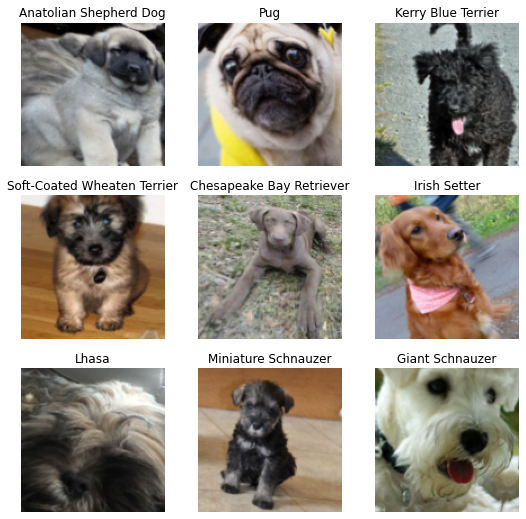

In [ ]:
dls.train.show_batch()

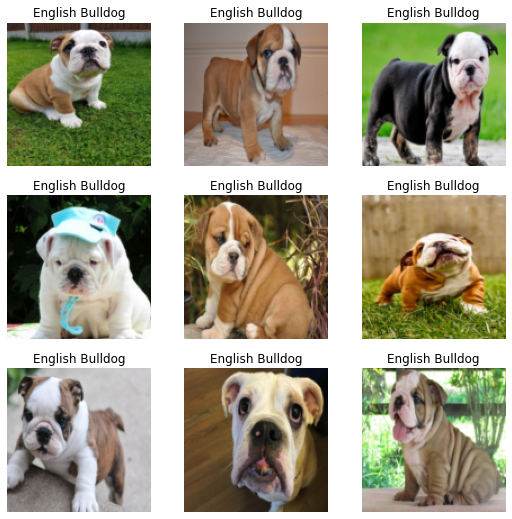

In [ ]:
# good! we have data in the validation set
# notice: no transformations/augmentation done to validation set, only resize/crop
dls.valid.show_batch()

# Model training & interpretation

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


(0.006918309628963471, 0.002511886414140463)


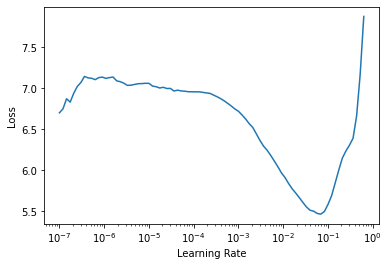

In [ ]:
set_seed(SEED, dls=dls)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
print((lr_min, lr_steep))

In [ ]:
# 3 epochs with ResNet layers frozen, training new layers
# 5 additional epochs

set_seed(SEED, dls=dls)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(epochs=5, 
                freeze_epochs=3, 
                base_lr=lr_steep)
                #cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=5))

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.w

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.w

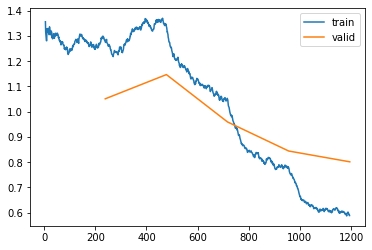

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

# Instead of showing confusion matrix (which would be 120x120, since we have 120 dog breeds) [149 with added breeds],
# get counts of the breeds that were most confused for one another
interp.most_confused(min_val=5)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[('Miniature Poodle', 'Toy Poodle', 14),
 ('Toy Poodle', 'Miniature Poodle', 11),
 ('Malamute', 'Siberian Husky', 10),
 ('Entlebucher Mountain Dog', 'Greater Swiss Mountain Dog', 9),
 ('Labradoodle', 'Goldendoodle', 9),
 ('Miniature American Shepherd', 'Australian Shepherd', 9),
 ('Appenzeller', 'Entlebucher Mountain Dog', 7),
 ('Standard Poodle', 'Toy Poodle', 7),
 ('Toy Terrier', 'Miniature Pinscher', 7),
 ('Wirehaired Pointing Griffon', 'German Wirehaired Pointer', 7),
 ('Akita', 'Shiba Inu', 6),
 ('Appenzeller', 'Greater Swiss Mountain Dog', 6),
 ('Blenheim Spaniel', 'Cavalier King Charles Spaniel', 6),
 ('Bull Terrier', 'Staffordshire Bullterrier', 6),
 ('Cavalier King Charles Spaniel', 'Blenheim Spaniel', 6),
 ('English Mastiff', 'Bull Mastiff', 6),
 ('Eskimo Dog', 'Samoyed', 6),
 ('Irish Wolfhound', 'Scottish Deerhound', 6),
 ('Norfolk Terrier', 'Norwich Terrier', 6),
 ('Whippet', 'Italian Greyhound', 6),
 ('Australian Terrier', 'Norwich Terrier', 5),
 ('Beagle', 'English Foxhou

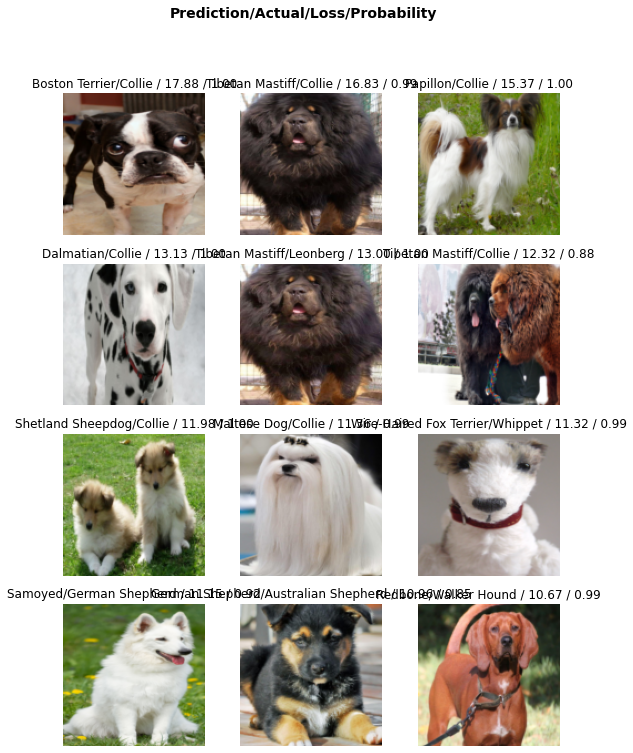

In [ ]:
# show the images with the highest losses in our dataset
# titles are: (prediction, actual, loss, and probability)
interp.plot_top_losses(12, nrows=4)

In [ ]:
# save our model
learn.export(os.path.join(gdrive_path, "dogs_online_resnet50_fastai_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

# Evaluate on test set

In [ ]:
test_images = get_image_files('/root/.fastai/data/test_images')
test_true_y = [parent_label(x) for x in test_images]
test_dl = learn.dls.test_dl(test_images)

probs, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)
test_pred_y = [learn.dls.vocab[x] for x in preds.numpy()]

# test set accuracy
test_acc = sum([y0 == y1 for y0, y1 in zip(test_true_y, test_pred_y)]) / len(test_images)
print(f'Test set accuracy: {test_acc:.4f}')

Test set accuracy: 0.7535


In [ ]:
# double-check: look at the first 5 and last 5
[test_true_y[:5], test_pred_y[:5],
 test_true_y[-5:], test_pred_y[-5:]]

[['English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog'],
 ['Boston Terrier',
  'French Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog'],
 ['Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo'],
 ['Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Toy Poodle',
  'Portuguese Water Dog',
  'Lagotto Romagnolo']]

# Classify dogs I know

In [ ]:
# assuming we are running this in a subsequent session, so we have to reload the learner
learn = load_learner("dogs_simpleplus_resnet50_fastai_20210107_030239.pkl")

## Upload one image at a time, using widgets

Note: widgets do not appear in nbviewer, and so results don't show up in GitHub

In [33]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
output_html = widgets.HTML()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # resize the image to have a maximum height of 200 pixels, then encode to base 64
    b = BytesIO()
    new_height = 200
    new_width = int((new_height / img.height) * img.width)
    img = img.resize((new_width, new_height))
    img.save(b, format='png')
    img_base64 = "<img height='200' src='data:image/png;base64,{}'/>".format(b64encode(b.getvalue()).decode('utf-8'))
    
    # update the html to include (1) the new image, base 64 encoded; (2) the top prediction and the
    # next 5 best; and (3) the previous outputs, if any
    output_html.value = img_base64 + "<br>" + \
        f'<b>Best guess: <u>{top_pred[0]}</u> (confidence: {100*top_pred[1]:.02f}%)</b><br>' + \
        "Next best:" + \
        "<ul>" + ''.join([f'<li>{x[0]} ({100*x[1]:.02f}%)</li>' for x in top5_preds]) + "</ul>" + \
        "\n\n<hr>\n" + output_html.value

btn_run.on_click(on_click_classify)

vb = VBox([widgets.Label('Upload an image of a dog'), 
      btn_upload, 
      btn_run, 
      output_html])

vb

## Classify images in directory on GitHub

In [34]:
# get GitHub access token
with open('github_key.key', 'r') as f:
    g = Github(f.read())

In [35]:
# list all images
repo = g.get_repo("willjobs/dog-classifier")
dog_images = repo.get_contents("dog_images")
dog_images = [img.download_url for img in dog_images if img.download_url[-2:] != "md"]  # exclude readme
dog_images

['https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_000.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_001.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_002.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_003.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_004.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_005.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_006.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_007.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_008.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_009.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File

In [36]:
# allows us to include markdown formatting in our print statements
def printmd(string):
    display(Markdown(string))

Processing File_000.jpeg...


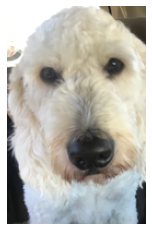

**Best guess: Soft-Coated Wheaten Terrier (confidence: 44.14%)**

Next best:

* Giant Schnauzer (10.24%)
* Otterhound (10.13%)
* Sealyham Terrier (5.80%)
* Komondor (4.62%)
* Goldendoodle (3.86%)

---

Processing File_001.jpeg...


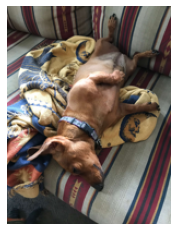

**Best guess: Dachshund (confidence: 35.64%)**

Next best:

* Collie (28.27%)
* Miniature Pinscher (3.01%)
* Brabancon Griffon (2.65%)
* Chinese Shar-Pei (1.98%)
* Bloodhound (1.59%)

---

Processing File_002.jpeg...


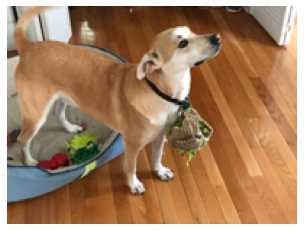

**Best guess: Italian Greyhound (confidence: 89.35%)**

Next best:

* Whippet (4.75%)
* Saluki (1.27%)
* Dachshund (0.72%)
* Rat Terrier (0.68%)
* Weimaraner (0.57%)

---

Processing File_003.jpeg...


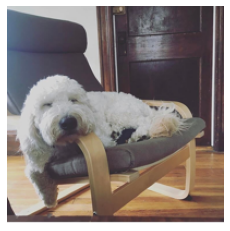

**Best guess: Komondor (confidence: 92.07%)**

Next best:

* Soft-Coated Wheaten Terrier (2.18%)
* Bedlington Terrier (1.07%)
* Bichon Frise (0.80%)
* Kuvasz (0.65%)
* Standard Poodle (0.35%)

---

Processing File_004.jpeg...


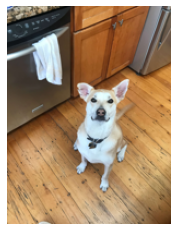

**Best guess: Shiba Inu (confidence: 50.49%)**

Next best:

* Russell Terrier (9.54%)
* Rat Terrier (5.68%)
* Carolina Dog (3.58%)
* Bull Terrier (3.25%)
* Pembroke Welsh Corgi (2.67%)

---

Processing File_005.jpeg...


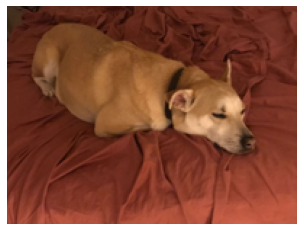

**Best guess: Carolina Dog (confidence: 44.52%)**

Next best:

* Italian Greyhound (10.60%)
* Whippet (9.39%)
* Chinese Shar-Pei (5.46%)
* Staffordshire Bullterrier (3.99%)
* Collie (3.46%)

---

Processing File_006.jpeg...


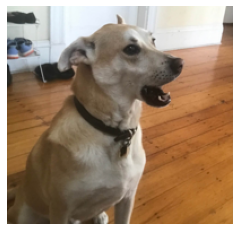

**Best guess: Whippet (confidence: 93.58%)**

Next best:

* Italian Greyhound (3.82%)
* Carolina Dog (0.72%)
* Anatolian Shepherd Dog (0.38%)
* Bull Terrier (0.26%)
* Russell Terrier (0.25%)

---

Processing File_007.jpeg...


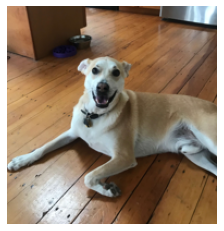

**Best guess: Rat Terrier (confidence: 15.85%)**

Next best:

* Whippet (12.78%)
* Carolina Dog (12.47%)
* Staffordshire Bullterrier (11.52%)
* Russell Terrier (9.46%)
* Shiba Inu (8.12%)

---

Processing File_008.jpeg...


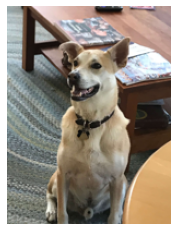

**Best guess: Carolina Dog (confidence: 87.36%)**

Next best:

* Whippet (3.53%)
* Anatolian Shepherd Dog (2.93%)
* Collie (1.13%)
* Rat Terrier (1.12%)
* Bull Terrier (1.05%)

---

Processing File_009.jpeg...


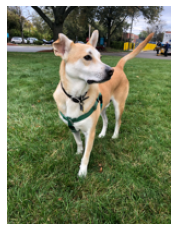

**Best guess: Carolina Dog (confidence: 56.37%)**

Next best:

* Rat Terrier (14.97%)
* Basenji (10.34%)
* Whippet (7.91%)
* Shiba Inu (2.07%)
* Pembroke Welsh Corgi (1.33%)

---

Processing File_010.jpeg...


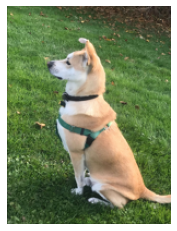

**Best guess: Carolina Dog (confidence: 27.43%)**

Next best:

* Basenji (24.44%)
* Rat Terrier (17.53%)
* Shiba Inu (6.05%)
* American Staffordshire Terrier (5.69%)
* Ibizan Hound (4.23%)

---

Processing File_011.jpeg...


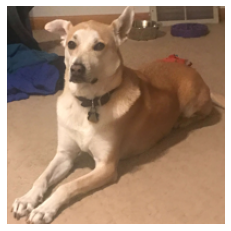

**Best guess: Labrador Retriever (confidence: 28.25%)**

Next best:

* Carolina Dog (17.40%)
* Whippet (9.47%)
* Anatolian Shepherd Dog (9.16%)
* Collie (4.72%)
* Bull Terrier (3.94%)

---

Processing File_012.jpeg...


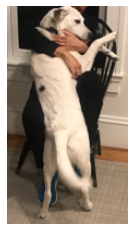

**Best guess: Leonberg (confidence: 43.74%)**

Next best:

* Bull Terrier (7.98%)
* Russell Terrier (7.26%)
* Kuvasz (4.11%)
* Carolina Dog (3.60%)
* Rat Terrier (2.70%)

---

Processing File_013.jpeg...


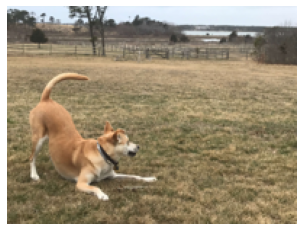

**Best guess: Pembroke Welsh Corgi (confidence: 28.97%)**

Next best:

* Akita (22.72%)
* Carolina Dog (12.27%)
* Cardigan Welsh Corgi (9.54%)
* Saluki (6.14%)
* Anatolian Shepherd Dog (2.91%)

---

Processing File_014.jpeg...


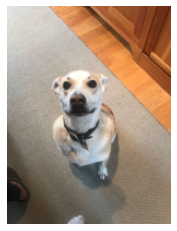

**Best guess: Labrador Retriever (confidence: 16.68%)**

Next best:

* Chihuahua (14.92%)
* Collie (13.98%)
* Shiba Inu (10.93%)
* Rat Terrier (9.36%)
* Carolina Dog (7.68%)

---

Processing File_015.jpeg...


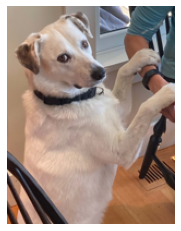

**Best guess: Carolina Dog (confidence: 64.77%)**

Next best:

* Italian Greyhound (13.78%)
* Whippet (6.70%)
* Rat Terrier (3.96%)
* Labrador Retriever (2.67%)
* Collie (1.15%)

---

Processing File_016.jpeg...


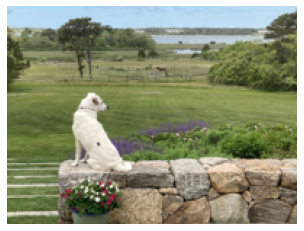

**Best guess: Leonberg (confidence: 37.11%)**

Next best:

* Ibizan Hound (18.97%)
* Borzoi (3.75%)
* Sealyham Terrier (3.15%)
* Saluki (2.54%)
* Anatolian Shepherd Dog (2.48%)

---

Processing File_017.jpeg...


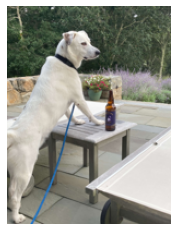

**Best guess: Bull Terrier (confidence: 47.23%)**

Next best:

* Staffordshire Bullterrier (14.44%)
* Whippet (10.67%)
* Bull Mastiff (4.34%)
* Labrador Retriever (2.65%)
* Anatolian Shepherd Dog (2.57%)

---

Processing File_018.jpeg...


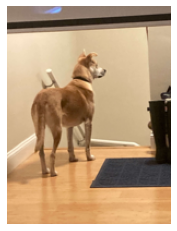

**Best guess: Carolina Dog (confidence: 90.22%)**

Next best:

* Kelpie (5.99%)
* Chihuahua (1.40%)
* Shiba Inu (0.43%)
* Pembroke Welsh Corgi (0.20%)
* Toy Terrier (0.19%)

---

Processing File_019.jpeg...


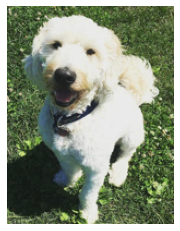

**Best guess: Komondor (confidence: 17.92%)**

Next best:

* Sealyham Terrier (16.16%)
* Old English Sheepdog (12.42%)
* Kuvasz (9.00%)
* Coton de Tulear (7.81%)
* Bichon Frise (7.69%)

---

Processing File_020.jpeg...


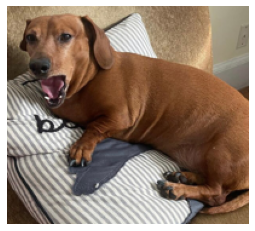

**Best guess: Dachshund (confidence: 39.98%)**

Next best:

* Rhodesian Ridgeback (37.72%)
* Collie (6.31%)
* Redbone (5.28%)
* Labrador Retriever (3.63%)
* Black-And-Tan Coonhound (1.59%)

---

Processing File_021.jpeg...


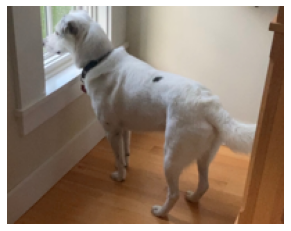

**Best guess: Mexican Hairless (confidence: 18.39%)**

Next best:

* Chinese Crested (16.16%)
* Kuvasz (12.41%)
* Bull Terrier (4.89%)
* Soft-Coated Wheaten Terrier (3.27%)
* Japanese Spaniel (2.77%)

---

Processing File_022.jpeg...


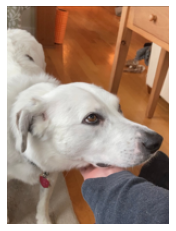

**Best guess: Great Dane (confidence: 58.58%)**

Next best:

* Bull Terrier (11.49%)
* Sealyham Terrier (4.50%)
* Weimaraner (4.21%)
* English Foxhound (4.19%)
* American Staffordshire Terrier (2.56%)

---

In [37]:
for url in dog_images:
    print(f"Processing {os.path.basename(url)}...")

    # must use PILImage.create, not Image.open, otherwise fastai doesn't work
    img = PILImage.create(requests.get(url, stream=True).raw)

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # output (1) the image (resized)
    #        (2) the top prediction
    #        (3) the next 5 best
    
    outstr = f"**Best guess: {top_pred[0]} (confidence: {100*top_pred[1]:.02f}%)**\n\n" + \
        "Next best:\n\n" + \
        '* ' + '\n* '.join([f'{x[0]} ({100*x[1]:.02f}%)' for x in top5_preds]) + \
        "\n\n---"

    plt.imshow(img.to_thumb(h=200))
    plt.axis('off')
    plt.show(block=False)  # forces plots to show immediately, interspersed with text, not at the end

    printmd(outstr)